# Práctica de Deep Learning por Blanca Martín Muñoz

Según el enunciado de la prática, nos basamos en el guión ofrecido para realizar esta práctica de Deep Learning. El objeticvo principal de la prática es intentar contruir un modelo que prediga la condición médica sufrida por una cohorte de pacientes a partir de las diferentes fuentes de información, que son imágenes y datos tabulares.

Entonces según el guión dado, damos los mismos pasos:

# 1. Carga de dataset

Copiando los datos en una carpeta propia del drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

DATA_DIR = "/content/drive/MyDrive/PRACTICA_DL/data/"
print(os.listdir(DATA_DIR))

['hnmist_28_28_RGB.csv', 'HAM10000_metadata.csv']


In [5]:
# Una vez montado el directorio con los datasets, los leemos para entender que hay en ellos:

import pandas as pd
import numpy as np

data_img = pd.read_csv(DATA_DIR + "hnmist_28_28_RGB.csv")
print("Estos son los datos de imagen:\n", data_img.head(3))
print("Tiene este tamaño:\n", data_img.shape)

data_tabular = pd.read_csv(DATA_DIR+ "HAM10000_metadata.csv")
print("Estos son los datos tabulares:\n", data_tabular.head(3))
print("Tiene este tamaño:\n", data_tabular.shape)

Estos son los datos de imagen:
    pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2342  pixel2343  \
0        197        154        185        202  ...        134        173   
1        123         93        126        158  ...         82         60   
2        201        142        160        206  ...        149        167   

   pixel2344  pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  \
0        124        138        183        147        166        185   
1         39         55         25         14         28         25   
2        129        143        159        124        142        136   

   pixel2350  pixel2351  
0        154        177  
1         14         27  
2        104   

Como se puede ver, los datos en relación a la imagen se forma con 10015 muestras/fotos (como se indicaba en el guion) y 2352 columnas/pixeles que, metiendote en kaggle, puedes ver que se trata de imagenes a color (3 canales). Por tanto, como 2352/3 =784, y su raiz cuadra es 28, podemos decir que son imagenes 28x28x3  (a color RGB). También se puede ver esto por el propio nombre del fichero, donde se indica el tamaño lateral de las imágenes contenidas en él.

Por otro lado, en cuanto a los datos tabulares, podemos ver que es un  dataset con el mismo número de filas/muestras y con 7 columnas. Las dos primeras son identificadores, por lo que se entiende que image_id vincula cada fila con una imagen del otro dataset. Por otro lado, tenemos dx y dx_Type que seguramente sea el diagnóstico, lo cual funciona como label/target, aunque ahora invetsigaremos más. Las últimas tres columnas son las que utilizaremos como features para crear nuestro modelo 1D tabular.

#HITO 1: MODELO 1D TABULAR

## 1.1 Preprocesamiento de dataset tabular:

En un primer momento, como se pide para el primer hito crear un modelo 1D con los datos tabulares, se hace un preprocesamiento exclusivos de estos. También se indica en el enunciado que los datos tabulares a tener en cuenta son: age, sex, locazation

Entonces, investigando que nos da cada columna:

In [6]:
# Primero, para entender mejor los datos, ver qué es el diagnóstico, veremos sus valores únicos. Asi también veremos si existen valores nan que se deben imputar.

print(f'existen {len(data_tabular["lesion_id"].unique())} lesion distintas: {(data_tabular["lesion_id"].unique())}')
print(f'existen {len(data_tabular["image_id"].unique())} imagen_id distintas: {(data_tabular["image_id"].unique())}')
print(f'existen {len(data_tabular["dx"].unique())} dx distintas:{(data_tabular["dx"].unique())} ')
print(f'existen {len(data_tabular["dx_type"].unique())} dx_type distintas:{(data_tabular["dx_type"].unique())} ')
print(f'existen {len(data_tabular["age"].unique())} edades distintas: {(data_tabular["age"].unique())}')
print(f'existen {len(data_tabular["sex"].unique())} genero distintas: {(data_tabular["sex"].unique())}')
print(f'existen {len(data_tabular["localization"].unique())}) localizacion distintas: {(data_tabular["localization"].unique())}')

existen 7470 lesion distintas: ['HAM_0000118' 'HAM_0002730' 'HAM_0001466' ... 'HAM_0005579' 'HAM_0001576'
 'HAM_0002867']
existen 10015 imagen_id distintas: ['ISIC_0027419' 'ISIC_0025030' 'ISIC_0026769' ... 'ISIC_0033536'
 'ISIC_0032854' 'ISIC_0032258']
existen 7 dx distintas:['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 
existen 4 dx_type distintas:['histo' 'consensus' 'confocal' 'follow_up'] 
existen 19 edades distintas: [80. 75. 60. 70. 55. 85. 65. 40. 50. 45. 35.  0. 30. nan  5. 25. 20. 10.
 15.]
existen 3 genero distintas: ['male' 'female' 'unknown']
existen 15) localizacion distintas: ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


Para empezar, existen 10015 'image_id's diferentes, lo que confirma nuestra sospecha de que gracias a esta columna podemos relacionar cada fila a una foto del otro dataset. Sin embargo, en la columna lesion_id, vemos que existen tan solo 7470 valores distintos, esto nos podria indicar que existe en realidad 7470 casos pero hay más de una foto/consulta por caso, lo que da a 10015 imágenes distintas. Es necesario tener esto en cuenta a la hora de hacer la división train/test, ya que no debería caer el mismo caso en ambos dataset.

Por otro lado, vemos que la columna 'dx' se trata del diagnóstico (clasificación en los 7 tipos de enfermedades dermatológicas) que se explicaba en el enunciado, es decir, se trata del label de nuestro problema. Además, en la columna 'dx_type' encontramos cómo se confirmó este diagnóstico, es decir, si se hizo por biopsia, por microscopía confocal, por seguimiento o por conseso. Obviamente, esta columna no debería incluirse como variable predictora porque se trata de la confirmación de lo que se puede sospechar un médico, es decir, el objetivo es que el modelo prediga este diagnostico sin tener esta confirmación del diagnóstico por una prueba, conseso o seguimiento médico. Esto mismo ya se intuye en el enunciado al presentarse las variables predictoras a utilizar.

Por último, vemos las últimas tres columnas que se utilizaran como features/predictores: edad, género y localización. Se ve que en la edad existen valores nulos que habrá que imputarlos, y en género y localización existe la clase'unkown' que se pede tratar como una clase más en vez de imputar pues no son valores que falten.

En resumen, no se trata de un datataset en el que hay que hacer un preprocesamiento muy exhaustivo. Por ejemplo, no es necesario eliminar columnas por información redundante, o por el conocimiento del dominio aparte de centrarnos simplemente en las variables indicadas en el guión.


### 1.1.1 Filtrar carcateristicas que no son predictoras y definir label:

Como se ha explicado antes, se debe eliminar las columnas sobre información de id que no aportan información útil para el modelo 1D que se aplicará después. Aunque se ha mencionado previamente que no se deberia utilizar el mismo caso ('lesion_id') en el dataset de entrenamiento y de evaluación porque no sería la realidad, en este caso no se a verificar. Al eliminar esta columna, resulta imposible verificar que se de esta condición. También, como se ha dicho, se  excluye la columna de 'dx_type'.

In [7]:
y_data = data_tabular["dx"]
x_data = data_tabular[["sex", "age", "localization"]]

print(y_data.value_counts())
print(x_data.head(5))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
    sex   age localization
0  male  80.0        scalp
1  male  80.0        scalp
2  male  80.0        scalp
3  male  80.0        scalp
4  male  75.0          ear


ES interesante ver con estos resultados que, dentro de las labels, hay una clase muy mayoritaria que es 'nv'. ESta destaca mucho por delante del resto y por tanto, esto se debe tener en cuenta a la hora de evaluar los modelos que se crearán posteriormente.

---



### 1.1.2 División train, val, test:

Como se estudió en el módulo anterior de ML, es importante hacer la división de datos en datasets de train y test lo antes posibles, para evitar el 'data leakage'. Al final, en el mundo real, puede que salgan datos/categorías nuevas que no se hayan contemplado antes.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=2, stratify=y_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2, stratify=y_train)


Ahora se hará el preprocesamiento según los datos del train dataset. Una vez finalizado, se aplicará lo mismo para los datasets de validación y test.

### 1.1.3 Categorización de variables:

Como ya sabemos, los modelos no pueden trabajar con datos no-numéricos, por lo que estos deben categorizarse en clases numéricas.

In [9]:
# Label: como se trata de 7 clases fáciles de categorizar, lo hacemos manualmente.
print((y_train.unique())) #cercioramos que verdaderamente tenemos las siete clases en nuestro subset train, que debería con el stratify

map_label = {}
for i, name in enumerate (y_train.unique()):
  map_label[name] = i

y_train = y_train.map(map_label)
print("las labels han sido categorizadas:", y_train.unique()) #chequeamos que ha funcionado la categorización

['nv' 'vasc' 'bkl' 'akiec' 'mel' 'bcc' 'df']
las labels han sido categorizadas: [0 1 2 3 4 5 6]


In [10]:
# Sexo: igual que label, es facil de categorizar segun un map
print((X_train['sex'].unique())) #cercioramos que verdaderamente tenemos las siete clases en nuestro subset train

map_sex = {}
for i, name in enumerate (X_train['sex'].unique()):
  map_sex[name] = i

X_train['sex'] = X_train['sex'].map(map_sex)
print("los generos han sido categorizadas:", X_train['sex'].unique())

['male' 'female' 'unknown']
los generos han sido categorizadas: [0 1 2]


In [11]:
# Para la localización, al tener más clases decidimos crear una columna por clase (one-hot enocding), por el método get_dummies, también estudiado en el módulo anterior: Esto se hace para que no de
# pie a confusión en el modelo pensando que una localization tiene un número mayor que otra y por tanto puede ser más probable o menos que otra, esto no estan relvante en sex al haber solo 3 clases.
# Ademas crear 15 columnas en un dataset de más de 10mil  muestras no es un problema
print(X_train["localization"].unique())
X_train = pd.get_dummies(X_train, columns=[ "localization"], dtype=int)

['trunk' 'lower extremity' 'abdomen' 'face' 'upper extremity' 'neck'
 'unknown' 'ear' 'chest' 'back' 'scalp' 'foot' 'hand' 'genital' 'acral']


In [12]:
X_train.head(10)

,sex,age,localization_abdomen,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
3288,0,45.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2999,0,50.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2444,1,70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
852,0,75.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6100,0,45.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7616,0,45.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9863,0,70.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
771,1,70.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7395,0,25.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
236,0,65.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### 1.1.4 Imputar valores nulos:

Sabemos que tanto en la columna **sex** y **localization** no existen estos valores missing, mientras que en la columna **age** si, por lo que lo imputamos con la mediana del datset train, ya que la media puede estar sesgadas por outliers.

In [13]:
edad_mediana = X_train['age'].median()
X_train['age'] = X_train['age'].fillna(edad_mediana)

# Para comprobar:
print(X_train['age'].isna().any())

False


### 1.1.5 Normalizar:

Como último paso, se debe normalizar las variables numericas que no se tratan de categorias, como es el caso de aga. Para ello, como hemos hecho en otros módulos utilizamos **StandarScaler**:



In [14]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_trainScaled = scaler.transform(X_train)


### 1.1.6 Se traslada a test y validation el mismo pre procesamiento

Una vez hemos finalizado el preprocesamiento en el dataset train, aplicamos las mismas transformaciones a los datsets de validación y evaluación.

In [15]:
# Categorizar labels:

y_test = y_test.map(map_label)
y_val = y_val.map(map_label)

# Categirizar columna sex:

X_test['sex'] = X_test['sex'].map(map_sex)
X_val['sex'] = X_val['sex'].map(map_sex)

# Categorizar get dummies
print('categorias de test:',X_test["localization"].unique() )
print('categorias de val:',X_val["localization"].unique() )
X_test = pd.get_dummies(X_test, columns=[ "localization"], dtype=int)
X_val = pd.get_dummies(X_val, columns=[ "localization"], dtype=int)


categorias de test: ['back' 'lower extremity' 'abdomen' 'unknown' 'upper extremity' 'trunk'
 'chest' 'hand' 'foot' 'face' 'neck' 'scalp' 'genital' 'ear']
categorias de val: ['trunk' 'upper extremity' 'lower extremity' 'back' 'face' 'abdomen'
 'chest' 'hand' 'foot' 'acral' 'ear' 'unknown' 'scalp' 'neck' 'genital']


In [16]:
# Como se ve que hay distintas clasificaciones en los distintos datsets, tenemos que alinear el 'get_dummies' para que todos los datasets tengan las mismas columnas:

X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)


In [17]:
# Imputamos valos nulos con la mediana obtenida del train:

X_test['age'] = X_test['age'].fillna(edad_mediana)
X_val['age'] = X_val['age'].fillna(edad_mediana)

# Normalizamos según la escala del train:

X_testScaled = scaler.transform(X_test)
X_valScaled = scaler.transform(X_val)

In [18]:
# Chequemos que todo esté correcto:

print("esto es train:", X_train.shape)
X_train.head(5)


esto es train: (4907, 17)


,sex,age,localization_abdomen,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
3288,0,45.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2999,0,50.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2444,1,70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
852,0,75.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6100,0,45.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [19]:
print("esto es test:", X_test.shape)
X_test.head(5)

esto es test: (3005, 17)


,sex,age,localization_abdomen,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
2130,1,50.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2932,1,40.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3507,0,35.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9280,1,35.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4850,1,50.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
print("esto es val:", X_val.shape)
X_val.head(5)

esto es val: (2103, 17)


,sex,age,localization_abdomen,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
3464,0,45.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1156,0,60.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3167,1,50.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2021,0,70.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4814,1,50.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Como es de esperar, los distintos datasets tiene distinto numero de filas, pero mismo número de columnas y en el mismo orden.

Por último, para preparar estos datos tabulares para un modelo 1D de multiclase, es necesario transformar a un array de clases:

In [21]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=7)

y_test_cat = to_categorical(y_test, num_classes=7)
y_val_cat = to_categorical(y_val, num_classes=7)

In [22]:
print(y_train_cat) # para chequear que todo esta correcto.

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [23]:
#Se utilizará despues para asegurar que utilizamos las mismas muestraas en el dataset de imagenes en el modelo 2D

train_idx = X_train.index
val_idx   = X_val.index
test_idx  = X_test.index

print (train_idx)

Index([3288, 2999, 2444,  852, 6100, 7616, 9863,  771, 7395,  236,
       ...
       5361,  833, 8858, 7737, 5874, 9828, 4960, 9893, 6989, 1022],
      dtype='int64', length=4907)


## 1.2 Creación y evaluación del modelo 1D:

Como se pide en el enunciado, se va a utilizar la libreria Keras para realizar un modelo de red neuronal avanzada que va a seguir una arquitectura funcional (y no secuencial) donde se indica las entradas y salidas del modelo.[texto del enlace](https://)

In [24]:
# COMO VISTO EN CLASE:

import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ======================== Hiper-parámetros de nuestra red QUE DEBEMOS OPTIMIZAR PARA OBTENER LAS MEJORES PRESTACIONES========================
lr = 0.0005
n_epochs = 30
batch_size = 32
# =============================================================================================================================

entradas = Input(shape=(X_trainScaled.shape[1],), name="tabular_input")
hidden_1 = Dense(32, activation="relu", name="dense_hidden1_32")(entradas)
hidden_2 = Dense(16,activation="relu", name="dense_hidden2_16")(hidden_1)
salidas = Dense(y_train_cat.shape[1], activation="softmax", name="output")(hidden_2) # Para la clasificación multiclase, siempre softmax la función de activación última
model_1D = Model(inputs= entradas, outputs= salidas)

# Compilamos
model_1D.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"]) # Se crea el model_1Do al compilar todo lo indicado anteriormente,
                                                                                            # se utiliza categorical_crossentropy porque es la que se ha visto que mejor funcionaba en la clasficiaion multiclase
                                                                                            # En cuanto al optimizar, se podría haber utilizado SGD, pero por tener un optimizador más afinado, se toma Adam, para que tenga en cuenta el momento

model_1D.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tabular_input (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden1_32 (Dense)        │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden2_16 (Dense)        │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,223 (4.78 KB)

 Trainable params: 1,223 (4.78 KB)

 Non-trainable params: 0 (0.00 B)

[INFO]: Entrenando red neuronal...
Epoch 1/30
154/154 - 4s - 27ms/step - accuracy: 0.5525 - loss: 1.4514 - val_accuracy: 0.6833 - val_loss: 1.1134
Epoch 2/30
154/154 - 1s - 3ms/step - accuracy: 0.6890 - loss: 1.0348 - val_accuracy: 0.6985 - val_loss: 0.9977
Epoch 3/30
154/154 - 1s - 3ms/step - accuracy: 0.6949 - loss: 0.9694 - val_accuracy: 0.6990 - val_loss: 0.9696
Epoch 4/30
154/154 - 0s - 3ms/step - accuracy: 0.6974 - loss: 0.9449 - val_accuracy: 0.6995 - val_loss: 0.9571
Epoch 5/30
154/154 - 1s - 4ms/step - accuracy: 0.6980 - loss: 0.9321 - val_accuracy: 0.6995 - val_loss: 0.9483
Epoch 6/30
154/154 - 1s - 3ms/step - accuracy: 0.6992 - loss: 0.9230 - val_accuracy: 0.7009 - val_loss: 0.9411
Epoch 7/30
154/154 - 1s - 4ms/step - accuracy: 0.6994 - loss: 0.9167 - val_accuracy: 0.7014 - val_loss: 0.9373
Epoch 8/30
154/154 - 1s - 5ms/step - accuracy: 0.7004 - loss: 0.9104 - val_accuracy: 0.7023 - val_loss: 0.9325
Epoch 9/30
154/154 - 1s - 5ms/step - accuracy: 0.6996 - loss: 0.9055 - val_a

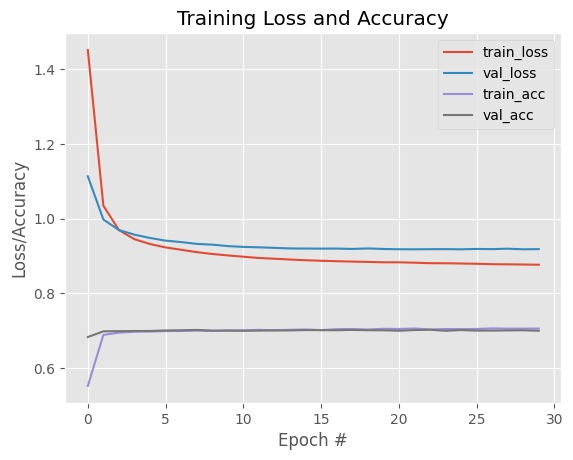

In [25]:
#Entrenamos modelo
print("[INFO]: Entrenando red neuronal...")
H = model_1D.fit(X_trainScaled, y_train_cat, validation_data=(X_valScaled, y_val_cat), epochs=n_epochs, batch_size=batch_size, verbose = 2) # Se crear el objeto del modelo que tiene las actualizaciones del entrenamiento, guardandose su última actualización en la variable model

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [26]:
# Evaluando el modelo de predicción con los datos tabulares de test
print("[INFO]: Evaluando red neuronal...")
predictions = model_1D.predict(X_testScaled, batch_size=batch_size) # Se evalúa el modelo
print(classification_report(y_test_cat.argmax(axis=1), predictions.argmax(axis=1)))

[INFO]: Evaluando red neuronal...
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.75      0.97      0.84      2012
           1       0.00      0.00      0.00        43
           2       0.40      0.38      0.39       330
           3       0.75      0.03      0.06        98
           4       0.26      0.03      0.06       334
           5       0.16      0.02      0.03       154
           6       0.00      0.00      0.00        34

    accuracy                           0.70      3005
   macro avg       0.33      0.21      0.20      3005
weighted avg       0.61      0.70      0.62      3005



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Se ha ido probando distintos valores de hiper-parametros. Desde:
- Learning rate: 0.0005, 0.001, 0.002 y 0.01, desechando este último de forma inmediata.
- batch size: se ha probado con 32, 64, 50, 80, 100 teniendo en mente que siempre es mejor que sea potencia del 2.
- numero de época: se ha probado también entre 20, 30, 40, 50, 100, viendo que no era necesario llegar a valores tan altos.

Cuando se ha ido variando los paraémtros se ha tenido en cuenat que normalmente, el batch size y el lerning rate deben ir de la mano. De tal manera que si la size es pequeño, y por tanto, no engloba todo el problema, el paso que se de sea más pequeño.

Aun probando distintos valores no se ha podido llegar a mejores prestaciones de las que se presenatn anteriormente (accuracy tanto en train como en test del 0.7). Aunque no son los mejores valores, por lo menos se puede ver que no existe un overfitting, y, además,teniendo en cuenta la simplicidad de los datos, solo demográficos y sin imagenes, es esperable que no se llegue a mejores prestaciones.

Sin embargo, en un último intento de conseguir mejores datos, se va a valorar el hecho de que exista dentro de las clasificaciones/labels una clase muy mayoritaria. Para comepsar este sesgo que puede traer el propio datset se va utilizar lo que ya fue presentando en el módulo de ML, el class weigth. ESto lo que hace es 'castigar más' cuando se equivoque en clases minoritarias.

In [27]:
from sklearn.utils.class_weight import compute_class_weight

categorias = y_train.unique()

pesos_clases = compute_class_weight(class_weight="balanced", classes=categorias, y=y_train)

peso_clase_dict =  {int(clas): float(peso) for clas, peso in zip(categorias, pesos_clases)}

print(peso_clase_dict)
print(y_train.value_counts())

{0: 0.21339421613394216, 1: 10.159420289855072, 2: 1.3029739776951672, 3: 4.38125, 4: 1.283882783882784, 5: 2.7817460317460316, 6: 12.298245614035087}
dx
0    3285
4     546
2     538
5     252
3     160
1      69
6      57
Name: count, dtype: int64


[INFO]: Entrenando red neuronal...
Epoch 1/30
154/154 - 7s - 45ms/step - accuracy: 0.7012 - loss: 2.1664 - val_accuracy: 0.6871 - val_loss: 0.9349
Epoch 2/30
154/154 - 1s - 8ms/step - accuracy: 0.6927 - loss: 1.9827 - val_accuracy: 0.6838 - val_loss: 0.9755
Epoch 3/30
154/154 - 2s - 15ms/step - accuracy: 0.6829 - loss: 1.8617 - val_accuracy: 0.6695 - val_loss: 1.0243
Epoch 4/30
154/154 - 2s - 12ms/step - accuracy: 0.6772 - loss: 1.7778 - val_accuracy: 0.6510 - val_loss: 1.0756
Epoch 5/30
154/154 - 2s - 11ms/step - accuracy: 0.6709 - loss: 1.7189 - val_accuracy: 0.6491 - val_loss: 1.1234
Epoch 6/30
154/154 - 1s - 5ms/step - accuracy: 0.6582 - loss: 1.6756 - val_accuracy: 0.6320 - val_loss: 1.1692
Epoch 7/30
154/154 - 1s - 3ms/step - accuracy: 0.6485 - loss: 1.6434 - val_accuracy: 0.6234 - val_loss: 1.2142
Epoch 8/30
154/154 - 1s - 3ms/step - accuracy: 0.6262 - loss: 1.6200 - val_accuracy: 0.5768 - val_loss: 1.2512
Epoch 9/30
154/154 - 1s - 3ms/step - accuracy: 0.5619 - loss: 1.6023 - va

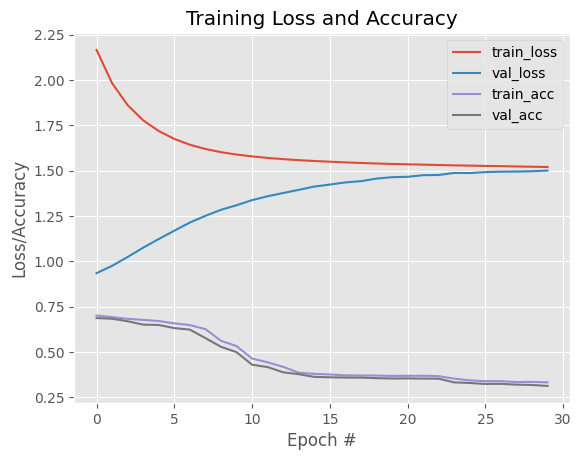

In [28]:

print("[INFO]: Entrenando red neuronal...")
model_1D_penalizado = Model(inputs= entradas, outputs= salidas)
model_1D_penalizado.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])
H_penalizado = model_1D_penalizado.fit(X_trainScaled, y_train_cat, validation_data=(X_valScaled, y_val_cat), epochs=n_epochs, batch_size=batch_size,verbose = 2, class_weight=peso_clase_dict) # Se crear el objeto del modelo que tiene las actualizaciones del entrenamiento, guardandose su última actualización en la variable model


# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H_penalizado.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H_penalizado.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H_penalizado.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H_penalizado.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Se ha podido ver que, al final, aunque el modelo deje de colapsar en la clase mayoritaria, no conseguimos que generalice de forma adecuada, siendo el entrenamiento completamente inestable.Pero, como ya se ha dicho, el primer modelo consigue unas prestaciones razonables, teneindo en cuenta el datset con el que partimos. En este dataset tabular existe no solo poca informacion de variable predictores, sino que hay un gran desbalanceo entre las muestras de las clases a predecir. Portanto, no tiene sentido tampoco intentar 'mejorar' el modelo añadiendo más capas ocultas, o con más neuornas, al ser el propio dataset muy sencillo.

ES por ello, que podemos decir que el modelo tabular va a servir como una buena baseline, que se utilizará en los proximos modelos con imagenes incluidas.


# HITO 2:

Una vez hemos terminado con nuestro modelo 1D de redes neuronales densas, pasamos a la "construccion" de una modelo 2d con una red convolucional (CNN). Para ello, se hará uso de una red convolucional ya preentrenada para extraer caracteristicas, conseguiendo así embeddings y entrenando solo el clasificador de estos. Esto es lo que se conoce como transfer-learning offline. Es cierto que podríamos haber entrenado nuestra propia CNN, teniendo en cuenta todos los parámetros a valorar (encontrar el número de capas de redes convolucionales necesarias, hacer un BatchNormalization, tener que implementar algún tipo de regularización, un pooling, hacer un flatten o un Global Average Pooling para pasar al clasificador...); sin embargo, es más eficiente y simple hacer un transfer-learning offline y así es lo que se propone en el enunciado como idea principal.

Para ello, como todos los modelos, empezamos con el preprocesamiento de la data, la cual en este caso son imagenes. ES importante darse cuenta que, con el dataset de imagenes, se debe hacer el mismo split antes hecho con la data tabular. Como necesitamos hacer posteriormente una fusión, además de comparar los modelos, es importante que las mismas muestras estén en el dataset de train de imagenes y en el train de los datos tabulares. Por ello, como habíamos visto antes, al haber en cada fila/muestra del dataset tabular una columna con image_id, vinculando a la imagen/muestra del dataset de imágenes, cogemos los índices de dataset train como referencia para saber donde hacer el split:

## 2.1 Preprocesamiento del dataset con imágenes


In [29]:
# Copiando la primera celda para facilitar la lectura de codigo
data_img = pd.read_csv(DATA_DIR + "hnmist_28_28_RGB.csv")

# Como se ha hecho en clase con el dataset MINST se debe normalizar los valores teniendo en cuenta de uq elos valores de RGB son de 255. Esto puede hacerse antes del split pues es no causa un data leakage:
#data_img = data_img/255 se quita esta preprocesameinto porque se usará la del modelo preentrenado

print("Estos son los datos de imagen:\n", data_img.head(3))
print("Tiene este tamaño:\n", data_img.shape)


Estos son los datos de imagen:
    pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2342  pixel2343  \
0        197        154        185        202  ...        134        173   
1        123         93        126        158  ...         82         60   
2        201        142        160        206  ...        149        167   

   pixel2344  pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  \
0        124        138        183        147        166        185   
1         39         55         25         14         28         25   
2        129        143        159        124        142        136   

   pixel2350  pixel2351  
0        154        177  
1         14         27  
2        104   

### 2.1.1. Division train, test, val:

Siguiendo los indices del split de los datos tabulares, dividimos el dataset de imagenes, para tener los mismos casos en los dos dataset (tabular e imagen)

In [30]:
# Cogiendo las variables ya definidas antes sobre los indices para hacer el split (se vuelve a definir para que sea más fácil seguir el código):

train_idx = X_train.index
test_idx = X_test.index
val_idx = X_val.index

ima_data_train = data_img.loc[train_idx]
ima_data_test = data_img.loc[test_idx]
ima_data_val = data_img.loc[val_idx]


### 2.1.2. Preprocesameinto:

Preparamos los datos para un modelo 2D. Actualmente, tenemos nuestro conjunto de datos de imágenes completamente normalizado y dividido en entrenamiento, prueba y validación correctamente. Ahora toca prepararlo para el modelo 2D, es decir, pasarlo de tener tensores 1D por cada muestra (lo que significa que los píxeles 28x28 que forman las imágenes en los 3 canales de RGB han sido aplanados, y podrían haber sido utilizados en el modelo 1D anterior con la normalización adecuada), a tensores de 3D de imágenes a color, propios para los inputs de los modelos preentrenados que vamos a utilizar. Para ello:

In [31]:
# SE pasa los dataset a numpy para que puedan ser redimensionas

ima_data_train=ima_data_train.values.astype("float32")
ima_data_test=ima_data_test.values.astype("float32")
ima_data_val=ima_data_val.values.astype("float32")


In [32]:
# se redimensiona el dataset de imagenes 'aplastados' a de nuevo un grupo de instancias de 28x28x3 canales RGB
ima_data_train = ima_data_train.reshape(-1, 28, 28, 3)
ima_data_test = ima_data_test.reshape(-1, 28, 28, 3)
ima_data_val = ima_data_val.reshape(-1, 28, 28, 3)

print('Esta es el dataset de imagenes TRAIN:', ima_data_train.shape, type(ima_data_train))
print('Esta es el dataset de imagenes TEST:', ima_data_test.shape)
print('Esta es el dataset de imagenes VAL:', ima_data_val.shape)

Esta es el dataset de imagenes TRAIN: (4907, 28, 28, 3) <class 'numpy.ndarray'>
Esta es el dataset de imagenes TEST: (3005, 28, 28, 3)
Esta es el dataset de imagenes VAL: (2103, 28, 28, 3)


## 2.2: Construcción y evalución de modelo convolucional (Transfer learning offline)

Como se ha dicho, se va a utilizar como modelo base para la extracción de características, un modelo convolucional ya preentrenado con el dataset de ImageNet (un dataset de imágenes de tamaño monumental). Para ello, se 'congelarán' todas las capas de este modelo, a excepción de la última de clasificación que se modificará según el dataset que nosotros utilizamos. Del mismo modo, al seguir este proceso, se debe inicializarse los pesos con aquellos de la libreria ImageNet, y se deberá hacer el preprocesamiento a nuestra dataset que sugiere el modelo base, pues los pesos inciales están en relación a él. Para ello:

In [33]:
# COMO VISTO EN CLASE:

# Por lo comentado en clase, el primer intento de CNN preentreanda sera el EfficienteNet, que suele entrenar con 224x224, pero utilizaremos 128x128 en este caso:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_effic


# LO PRIMERO DE TODO ES CAMBIAR EL TAMAÑO DE NUESTRO DATASET (TANTO DE TRAIN COMO DE VALIDACIÓN Y TEST, SEGÚN LO QUE PIDA EL MODELO QUE VAMOS A USAR).
# IGUALMENTE HAY QUE APLICAR EL MISMO PROCESO DE PREPROCESSING QUE DEFINE EL MODELO ELEGIDO.

input_shape = (128, 128)

# Se define funcion para redimensionar y hacer el preprocamiento requerido en el modelo:

def preprocess_model_1 (dataset, imag_size):
  dataset = tf.image.resize(dataset, imag_size)
  dataset = preprocess_input_effic(dataset)
  return dataset

ima_data_train_pp = preprocess_model_1(ima_data_train, input_shape)
ima_data_test_pp   = preprocess_model_1(ima_data_test,   input_shape)
ima_data_val_pp  = preprocess_model_1(ima_data_val,  input_shape)

print("Data preprocesada:")
print("Dataset_img_train_preprocesada:", ima_data_train_pp.shape, ima_data_train_pp.dtype)



Data preprocesada:
Dataset_img_train_preprocesada: (4907, 128, 128, 3) <dtype: 'float32'>


In [34]:
# construimos el modelo base
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128,128,3)) # no se incluye el top, para que solo se congelen las capas de extraccion de features
base_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [50]:
# COMO SE HA VISTO EN CLASE:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Por lo comentado en clase, el primer intento de CNN preentreanda sera el EfficienteNet, que suele entrenar con 224x224, pero utilizaremos 128x128 en este caso (Se dijo en clase que últimamente se esta utilizando este):
# queremos congelar todas las capas de nuestro base_model para que no se entrenen, en donde se ha quitado el clasificador
# haciendo que el feature extractor siga igual que antes para hacer transfer learning, es decir, coger embeddings
for layer in base_model.layers:
  layer.trainable = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
base_model_output = base_model.layers[-1].output
clasif = GlobalAveragePooling2D()(base_model_output)
clasif = Dense(256, activation='relu', name='hidden1')(clasif)
clasif = Dropout(0.5)(clasif)
clasif = Dense(128, activation='relu', name='fc2')(clasif)
clasif = Dropout(0.3)(clasif)

salida_clasif = Dense(y_train_cat.shape[1], activation='softmax', name='out_clasificador')(clasif)
model_eff = Model(base_model.input, outputs= salida_clasif, name = "EfficientNet_clasificador")

# compilamos el modelo
model_eff.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])

# vemos la estructura del modelo
model_eff.summary()

Model: "EfficientNet_clasificador"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,411,306 (16.83 MB)

 Trainable params: 361,735 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint # como se hizo varios intentos cmabiando leraning rate, batch size, numero de epocas,
                                                        #asi como las capas de la clasificacion de los modelos, y no se mejorarons las prestaciones, se decide coger el mejor checkpoint

# Se entrena el modelo
n_epochs =30
batch_size = 64

models_dir = "Best_checkpoint_effnet"
os.makedirs(models_dir, exist_ok=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(models_dir, "best_model.keras"), monitor='val_loss', mode="min", save_best_only=True, verbose = 1 )

H = model_eff.fit(ima_data_train_pp, y_train_cat,
          validation_data=(ima_data_val_pp, y_val_cat),
          batch_size=batch_size,
          epochs=n_epochs,
callbacks=[checkpoint])

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6298 - loss: 1.1837
Epoch 1: val_loss improved from inf to 0.83663, saving model to Best_checkpoint_effnet/best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 65s 530ms/step - accuracy: 0.6303 - loss: 1.1817 - val_accuracy: 0.7023 - val_loss: 0.8366
Epoch 2/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6903 - loss: 0.8963
Epoch 2: val_loss improved from 0.83663 to 0.78214, saving model to Best_checkpoint_effnet/best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6904 - loss: 0.8960 - val_accuracy: 0.7290 - val_loss: 0.7821
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7250 - loss: 0.8076
Epoch 3: val_loss improved from 0.78214 to 0.74542, saving model to Best_checkpoint_effnet/best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.7249 - loss: 0.8077 - val_accuracy: 0.7337 - val_loss: 0.7454
Epoch 4/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7341 - lo

[INFO]: Mejor época (val_loss mínima): 21  |  val_loss=0.6500


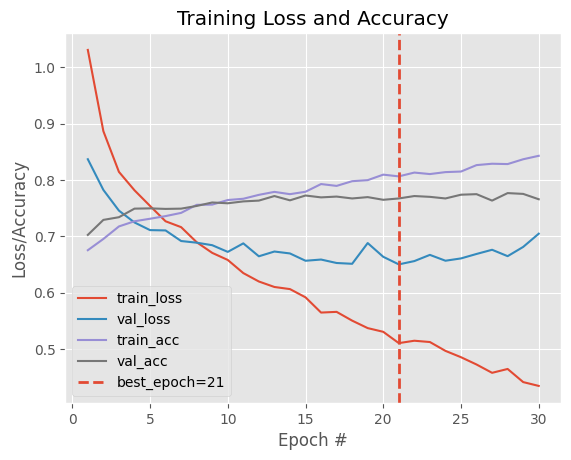

In [52]:
# Muestro gráfica de accuracy y losses, asi como el mejor modelo obtenido:

best_epoch = int(np.argmin(H.history["val_loss"])) + 1
best_val_loss = float(np.min(H.history["val_loss"]))
print(f"[INFO]: Mejor época (val_loss mínima): {best_epoch}  |  val_loss={best_val_loss:.4f}")

best_model_eff = tf.keras.models.load_model(os.path.join(models_dir,"best_model.keras"))

epocas_used = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, epocas_used+1), H.history["loss"], label="train_loss")
plt.plot(np.arange(1, epocas_used+1), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(1, epocas_used+1), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, epocas_used+1), H.history["val_accuracy"], label="val_acc")
plt.axvline(best_epoch, linestyle="--", linewidth=2, label=f"best_epoch={best_epoch}")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Como podemos ver por los resultados,llegamos a tener cierto overfitting pues el train accuracy es mejor que el accuracy del validation. Asimismo, no se observa el mismo decrecimiento en el loss en ambos datsets, lo que no es lo ideal. ES por ello, que aunque se haya probado distintas combinaciones de hiperparámetros, se decide utilizar la funcion de callbacks de checkpoint. De esta manera, se obtiene el modelo en la epoca que ha dado mejores prestaciones en cuanto al accuracy del dataset de validation.

In [38]:
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = best_model_eff.predict(ima_data_test_pp, batch_size=batch_size) # Se evalúa el modelo
print(classification_report(y_test_cat.argmax(axis=1), predictions.argmax(axis=1)))

# comprobamos el accuracy y el loss en el test set
scores = best_model_eff.evaluate(ima_data_test_pp, y_test_cat, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


[INFO]: Evaluando red neuronal...
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2012
           1       0.81      0.60      0.69        43
           2       0.51      0.43      0.47       330
           3       0.41      0.50      0.45        98
           4       0.50      0.31      0.39       334
           5       0.59      0.47      0.53       154
           6       0.50      0.12      0.19        34

    accuracy                           0.76      3005
   macro avg       0.60      0.48      0.51      3005
weighted avg       0.74      0.76      0.74      3005

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.7520 - loss: 0.6976
Test loss: 0.6721891164779663
Test accuracy: 0.7597337961196899


Por último evaluamos el modelo en el dataset test que hemos reservado. En este caso podemos ver que la accuracy puede que no sea la ideal, pero esta es pareciada a lo conseguido con el entranamiento, por lo que se ha evitado el overfitting con el checkpoint. Asimismo, como hemosvisto también con el anterior modelo, las metricas de evaluación están muy desbalanceadas. Minetras que accuracy, y weigth avg rondan los 75%, en el macro f1 avg se obtiene tan solo un 50%. Esto se explica mirando la tabla del clasification_report, donde podemos ver que la clase mayoritaria obtiene mejores valores que la minoritarias donde el modelo tiene dificultades, como es esperable por el gran desbalanceo de muestras por clases en el datset.



# HITO 3: late-fusion

Viendo que no se consigue las mejores prestaciones tanto con el modelo 1D tabular y el modelo 2D de imágenes a pesar de la busqueda por mejoras, pasamos a realizar un late-fusion de ambos modelos. Con esta estrategia de fusión, se busca intentar conseguir mejores prestaciones al combinar el 'conocimiento' de ambos modelos (tabulares e imágenes). En este primer caso, donde la fusión se hace 'tarde', es decir, tras haber sido ambos modelos preentrenados para predecir la clasificación final, se espera que cuando un modelo falle, el otro acierte, compensando los errores del otro entre ellos.

In [39]:
# COMO VISTO EN CLASE: TENEMOS QUE TENER EN CUENTA QUE YA TENEMOS PREPARADOS EL MODELO 1D Y EL MODELO 2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.regularizers import l2
# Se necesita las predicciones de ambos modelos para luego hacer una concatenación de estos, y hacer una ultima clasificacion para intentar compensar los errores de uno con el otro

# MODELO 1D: DATOS TABULARES
xtrainScaled_predictions = model_1D.predict(X_trainScaled, batch_size=32)
xtestScaled_predictions = model_1D.predict(X_testScaled, batch_size=32)
xvalScaled_predictions = model_1D.predict(X_valScaled, batch_size=32)

#MODELO 2D: IMAGENES
imaTrain_pp_predictions = best_model_eff.predict(ima_data_train_pp, batch_size=64)
imaTest_pp_predictions = best_model_eff.predict(ima_data_test_pp, batch_size=64)
imaVal_pp_predictions = best_model_eff.predict(ima_data_val_pp, batch_size=64)


# Fusión de las probabilidades concatenadas
LateF_train = np.concatenate([xtrainScaled_predictions, imaTrain_pp_predictions], axis = 1)
LateF_val = np.concatenate([xvalScaled_predictions, imaVal_pp_predictions], axis = 1)

print('Se ha hecho la prediccion de los tabulares', xtrainScaled_predictions.shape)
print('Se ha hecho la prediccion de las imagenes', imaTrain_pp_predictions.shape)
print('Se ha hecho la concatenación de los modelos (late fusion)', LateF_train.shape)

# Creación de modelo late fusion con su clasificador final:
inputs_LF = Input(shape=(LateF_train.shape[1],), name="fusion_input")
hidden_1 = Dense(8, activation="relu")(inputs_LF)
hidden_1 = Dropout(0.5)(hidden_1)
out_LF= Dense(y_train_cat.shape[1], activation="softmax", kernel_regularizer=l2(1e-4))(hidden_1)

late_fusion_model = Model(inputs=[inputs_LF], outputs=out_LF,  name="Late_Fusion_Model")

late_fusion_model.summary()

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step
Se ha hecho la prediccion de los tabulares (4907, 7)
Se ha hecho la prediccion de las imagenes (4907, 7)
Se ha hecho la concatenación de los modelos (late fusion) (4907, 14)


Model: "Late_Fusion_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fusion_input (InputLayer)       │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183 (732.00 B)

 Trainable params: 183 (732.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
late_fusion_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=["accuracy"])

models_dir_lf = "Best_checkpoint_lateFusion"
os.makedirs(models_dir_lf, exist_ok=True)
checkpoint_LF = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(models_dir_lf, "best_model_LF.keras"), monitor='val_loss', mode="min", save_best_only=True, verbose = 1 )

H_lateF = late_fusion_model.fit(
    LateF_train, y_train_cat,
    validation_data=(LateF_val, y_val_cat),
    epochs=30,
    batch_size=32,
    verbose=2,
    callbacks= [checkpoint_LF])


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.71818, saving model to Best_checkpoint_lateFusion/best_model_LF.keras
154/154 - 7s - 48ms/step - accuracy: 0.7601 - loss: 0.6138 - val_accuracy: 0.7703 - val_loss: 0.7182
Epoch 2/30

Epoch 2: val_loss did not improve from 0.71818
154/154 - 1s - 8ms/step - accuracy: 0.7567 - loss: 0.6184 - val_accuracy: 0.7718 - val_loss: 0.7211
Epoch 3/30

Epoch 3: val_loss did not improve from 0.71818
154/154 - 0s - 3ms/step - accuracy: 0.7593 - loss: 0.6088 - val_accuracy: 0.7713 - val_loss: 0.7196
Epoch 4/30

Epoch 4: val_loss did not improve from 0.71818
154/154 - 1s - 3ms/step - accuracy: 0.7601 - loss: 0.6056 - val_accuracy: 0.7718 - val_loss: 0.7227
Epoch 5/30

Epoch 5: val_loss did not improve from 0.71818
154/154 - 0s - 3ms/step - accuracy: 0.7552 - loss: 0.6122 - val_accuracy: 0.7713 - val_loss: 0.7188
Epoch 6/30

Epoch 6: val_loss did not improve from 0.71818
154/154 - 1s - 3ms/step - accuracy: 0.7567 - loss: 0.6102 - val_accuracy: 0.7703 

[INFO]: Mejor época (val_loss mínima): 26  |  val_loss=0.7205


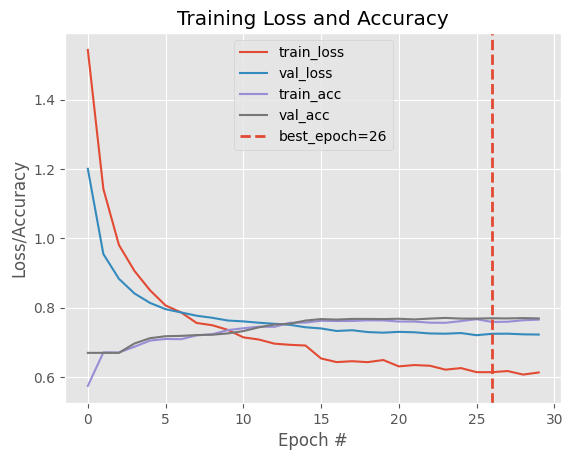

In [41]:
# Muestro gráfica de accuracy y losses

best_epoch = int(np.argmin(H_lateF.history["val_loss"])) + 1
best_val_loss = float(np.min(H_lateF.history["val_loss"]))
print(f"[INFO]: Mejor época (val_loss mínima): {best_epoch}  |  val_loss={best_val_loss:.4f}")

best_model_lf = tf.keras.models.load_model(os.path.join(models_dir_lf,"best_model_LF.keras"))

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H_lateF.history["loss"])), H_lateF.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H_lateF.history["loss"])), H_lateF.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H_lateF.history["loss"])), H_lateF.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H_lateF.history["loss"])), H_lateF.history["val_accuracy"], label="val_acc")
plt.axvline(best_epoch, linestyle="--", linewidth=2, label=f"best_epoch={best_epoch}")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Es cierto que tenemos cierto overfitting, pues como vemos en la gráfica el valor del accuracy del dataset de train es muucho mayor que el de validación. ES esperable por el ehcho que la dataset es muy básica, por lo que cualquier red neuronal un poco compleja, va a aprender muy rapido.


In [59]:
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
LateF_test = np.concatenate([xtestScaled_predictions, imaTest_pp_predictions], axis = 1)
predictions = late_fusion_model.predict(LateF_test, batch_size=32) # Se evalúa el modelo
print(classification_report(y_test_cat.argmax(axis=1), predictions.argmax(axis=1)))

# comprobamos el accuracy y el loss en el test set
scores = late_fusion_model.evaluate(LateF_test, y_test_cat, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

[INFO]: Evaluando red neuronal...
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2012
           1       0.81      0.40      0.53        43
           2       0.48      0.52      0.50       330
           3       0.00      0.00      0.00        98
           4       0.44      0.39      0.41       334
           5       0.67      0.44      0.53       154
           6       0.00      0.00      0.00        34

    accuracy                           0.76      3005
   macro avg       0.46      0.38      0.41      3005
weighted avg       0.71      0.76      0.73      3005

 1/94 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7500 - loss: 0.7817

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7465 - loss: 0.7959
Test loss: 0.7594830393791199
Test accuracy: 0.7554076313972473



# HITO 4: Early-fusion

En este caso, en vez de usar las predicciones de cada uno de los modelos que se van a fusionar, usaremos los embeddings de cada modelo previa a su clasificación. Es decir, crearemos un clasificador final que no se base en las probabilidad ya hechas por cada modelo, sino en las extracciones de cracateristicas. Esto se hace pensando que el problema que pueden tener cada modelo es con la clasificacion final al haber una relación entre los dataset, haciendo que les falte cierta información.

In [64]:
# Para hacer la early fusion, necesitamos entonces modelos intermedios (sin clasificador) de nuestros dos modelos anteriores:
"""for layer in best_model_eff.layers:
    print(layer.name)""" #para encontrar el nombre correspondinete
#Cogemos la ultima capa antes de nuestro clasificador, extrayendo las cracateristicas aprendidas por el modelo 1d y 2d:
emb_layer_name_1D = "dense_hidden2_16"
model_tab_intermediate = Model(inputs=model_1D.input, outputs=model_1D.get_layer(emb_layer_name_1D).output)

emb_layer_name_2D = "global_average_pooling2d_1"
model_eff_intermediate = Model(inputs=best_model_eff.input, outputs=best_model_eff.get_layer(emb_layer_name_2D).output)

#Extraemos los mebeddings de cada modelo intermedio:
#modelo 1d:
tab_emb_train = model_tab_intermediate.predict(X_trainScaled, batch_size=32)
tab_emb_test = model_tab_intermediate.predict(X_testScaled, batch_size=32)
tab_emb_val = model_tab_intermediate.predict(X_valScaled, batch_size=32)


#modelo 2d
ima_emb_train = model_eff_intermediate.predict(ima_data_train_pp, batch_size=64, verbose=1)
ima_emb_test  = model_eff_intermediate.predict(ima_data_test_pp,  batch_size=64, verbose=1)
ima_emb_val   = model_eff_intermediate.predict(ima_data_val_pp,   batch_size=64, verbose=1)


print("ima_emb_train:", ima_emb_train.shape)
print("ima_emb_test: ", ima_emb_test.shape)
print("ima_emb_val:", ima_emb_val.shape)

#Se fusionan:
EarlyF_train = np.concatenate([tab_emb_train, ima_emb_train], axis = 1)
EarlyF_val = np.concatenate([tab_emb_val, ima_emb_val], axis = 1)

print("Extracciones concatenada:", EarlyF_train.shape)

# Creación de modelo late fusion con su clasificador final:
inputs_EF = Input(shape=(EarlyF_train.shape[1],), name="Efusion_input")
hidden1 = Dense(64, activation="relu", name="fusion_fc1")(inputs_EF)
hidden2 = Dropout(0.5, name="fusion_dropout1")(hidden1)
hidden3 = Dense(32, activation="relu", name="fusion_fc2")(hidden2)
#hidden4 = Dropout(0.3, name="fusion_dropout2")(hidden3)
out_EF= Dense(y_train_cat.shape[1], activation="softmax", name="Efusion_out")(hidden3)

early_fusion_model = Model(inputs=[inputs_EF], outputs=out_EF,  name="early_Fusion_Model")

early_fusion_model.summary()




154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step
ima_emb_train: (4907, 1280)
ima_emb_test:  (3005, 1280)
ima_emb_val: (2103, 1280)
Extracciones concatenada: (4907, 1296)


Model: "early_Fusion_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Efusion_input (InputLayer)      │ (None, 1296)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fusion_fc1 (Dense)              │ (None, 64)             │        83,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fusion_dropout1 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fusion_fc2 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Efusion_out (Dense)             │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,319 (333.28 KB)

 Trainable params: 85,319 (333.28 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
early_fusion_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.5e-3), metrics=["accuracy"])

models_dir_ef = "Best_checkpoint_earlyFusion"
os.makedirs(models_dir_ef, exist_ok=True)
checkpoint_EF = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(models_dir_ef, "best_model_EF.keras"), monitor='val_loss', mode="min", save_best_only=True, verbose = 1 )

H_earlyF = early_fusion_model.fit(EarlyF_train, y_train_cat,validation_data=(EarlyF_val, y_val_cat),
            epochs=40,
            batch_size=64,
            verbose=2,
            callbacks= [checkpoint_EF])


Epoch 1/40

Epoch 1: val_loss improved from inf to 0.86346, saving model to Best_checkpoint_earlyFusion/best_model_EF.keras
77/77 - 5s - 59ms/step - accuracy: 0.6587 - loss: 1.1004 - val_accuracy: 0.7052 - val_loss: 0.8635
Epoch 2/40

Epoch 2: val_loss improved from 0.86346 to 0.79553, saving model to Best_checkpoint_earlyFusion/best_model_EF.keras
77/77 - 0s - 4ms/step - accuracy: 0.7031 - loss: 0.8913 - val_accuracy: 0.7261 - val_loss: 0.7955
Epoch 3/40

Epoch 3: val_loss improved from 0.79553 to 0.76245, saving model to Best_checkpoint_earlyFusion/best_model_EF.keras
77/77 - 0s - 4ms/step - accuracy: 0.7178 - loss: 0.8258 - val_accuracy: 0.7280 - val_loss: 0.7625
Epoch 4/40

Epoch 4: val_loss improved from 0.76245 to 0.73748, saving model to Best_checkpoint_earlyFusion/best_model_EF.keras
77/77 - 0s - 4ms/step - accuracy: 0.7222 - loss: 0.7897 - val_accuracy: 0.7470 - val_loss: 0.7375
Epoch 5/40

Epoch 5: val_loss improved from 0.73748 to 0.71167, saving model to Best_checkpoint_ear

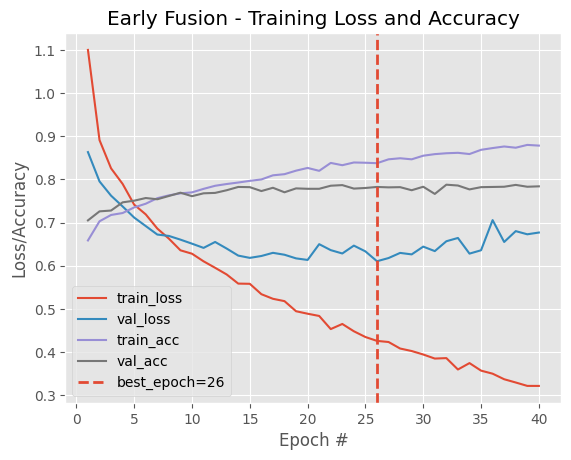

In [66]:
import matplotlib.pyplot as plt

best_epoch = int(np.argmin(H_earlyF.history["val_loss"])) + 1
epochs_ran = len(H_earlyF.history["loss"])
x = np.arange(1, epochs_ran + 1)

plt.style.use("ggplot")
plt.figure()

plt.plot(x, H_earlyF.history["loss"], label="train_loss")
plt.plot(x, H_earlyF.history["val_loss"], label="val_loss")
plt.plot(x, H_earlyF.history["accuracy"], label="train_acc")
plt.plot(x, H_earlyF.history["val_accuracy"], label="val_acc")

plt.axvline(best_epoch, linestyle="--", linewidth=2, label=f"best_epoch={best_epoch}")

plt.title("Early Fusion - Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

En este caso nos pasa como con el modelo 2D CNN: es necesario coger los mejores pesos según el entranamiento, porque, aunque no hay un claro overfitting, es cierto que el peso de la validación empieza aumentar mientras que el del entrenamiento conitnua disminuyendo.

In [70]:
EarlyF_test = np.concatenate([tab_emb_test, ima_emb_test], axis=1)
best_model_EF = tf.keras.models.load_model(os.path.join(models_dir_ef,"best_model_EF.keras"))

# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = best_model_EF.predict(EarlyF_test, batch_size=32) # Se evalúa el modelo
print(classification_report(y_test_cat.argmax(axis=1), predictions.argmax(axis=1)))

# comprobamos el accuracy y el loss en el test set
scores = best_model_EF.evaluate(EarlyF_test, y_test_cat, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

[INFO]: Evaluando red neuronal...
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2012
           1       0.67      0.33      0.44        43
           2       0.49      0.55      0.52       330
           3       0.52      0.44      0.48        98
           4       0.48      0.36      0.41       334
           5       0.70      0.49      0.58       154
           6       0.83      0.29      0.43        34

    accuracy                           0.77      3005
   macro avg       0.65      0.48      0.54      3005
weighted avg       0.76      0.77      0.76      3005

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7477 - loss: 0.6611
Test loss: 0.6351776123046875
Test accuracy: 0.7700499296188354


# 5. RESULTADOS Y DISCUSIÓN:

Aunque se ha ido haciendo una evaluación de cada modelo según se iba contruyendo, hacemos aquí una valoración más exhaustiva, comparando los resultados en los distintos modelos.

- Modelo tabular, resultados:

  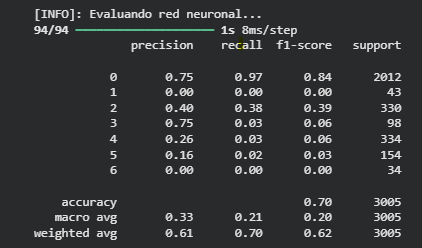

- Modelo 2D CNN con imágenes:

  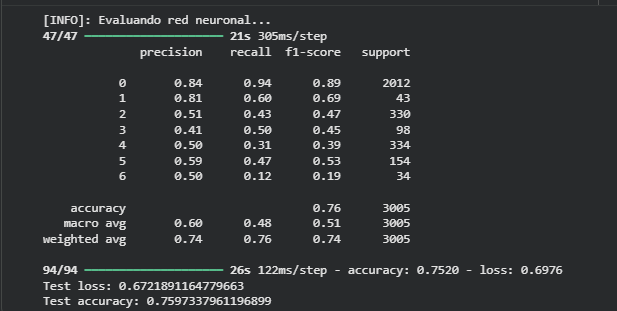

- Modelo Late fusion:

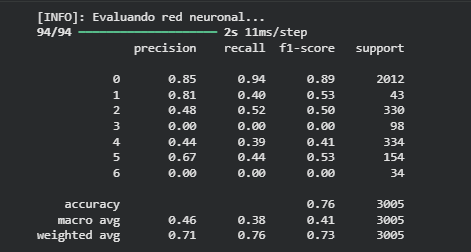

- Modelo Early Fusion:

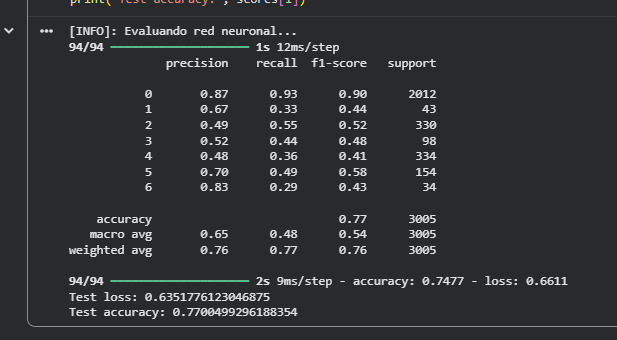

Podemos ver que el primer modelo, el tabular, aunque tiene un accuracy bastante adecuada (0.7), es cierto que si nos fijamos en la tabla, podemos ver ciertas clases minoritarias que no son bien predichas. Al final, como se ha ido comentado, era normal no encontrar las mejores prestaciones en un modelo que juega con 3 variables (sexo, edad y localización). Estas no contienen la información suficiente para poder clasificar en 7 clases las predicciones. Esto se puede ver en la metrica macro-F1 cuyo valor es 0.20. Esta métrica trata a todas las clases de igual manera, sin basarse en su frecuencia, por lo que no está influenciada por la clase mayoritaria. Como se ha dicho, y se vió en una de las primeras celdas, existe una clase muy mayoritaria (más de 6000 muestras en comparación con otras clases de 1000 o incluso de 100), haciendo que haya una base de 66% aprox, que hay que tener en cuenta al valorar los resultados de nuestras métricas. En resumen, la accuracy puede ser engañosa porque no enseña de forma clara el desbalance que existe entre las clases mayoritarias y minoritarias, por lo que es macro-F1 la que nos indica que este modelo no es 'tan bueno' como parece. Aunque se intentó 'arreglar' el desbalanceo de las clases en el modelo añadiendo class_weigths, los resultados fueron nefastos. Por tanto, se puede concluir que este modelo solo nos sirve como base line.
También se podría aplicar el mismo modelo al dataset de imágenes, pues estas ya estaban'aplastadas' para ser el input de este tipo de modelo 1D. Previamente se haría una normalizacion con StandarScaler para cada uno de los canales de colores. Esto no se hizo por falta de tiempo.

Por otro lado, en el modelo 2D CNN con los datos de las imágenes se consigue una mejora en cuanto a las prestaciones. Al tener las imaegnes la verdadera información significatova del dataset, la accuracy se eleva a 0.75, y lo más importante el Macro F1 se elva a 0.51. Esto quiere decir que el modelo consigue clasifficar de mejor manera, en comparación con el anterior, las clases minoritarias se clasifican mejor. Es cierto que, en el  entrenamiento del modelo, se pasó por un proceso de prueba-y-error en busca de los hiperparametros óptimos. Debido esto y tras multiples intentos fallidos, se decidió hacer uso de checkpoint, pues se vió que hasta cierto punto se podía tomar por bueno la generalización del modelo durante las distintas épocas del entrenamiento. También se quiso aplicar otros modelos preentrenados; por ejemplo, ResNet, que se puede incluir imagenes más pequeñas como entradas, no distorsionando tanto el dataset de imágenes original, sin embargo, no se pudo hacer por el tiempo. Otra opción hubiese sido es tener más en cuenta nuestra datset desbalanceada, y haber entrenado ciertas capas convolucionales del modelo seleccionado, haciendo fine-tunning.

En cuanto a los distintos modelos de fusión se puede ver que el primero, late-fusion, no aporta ninguna información beneficioso. Es decir, si nos fijamos en las metricas, la accuracy se mantiene, mientras que macro-F1,la importa en clases desbalanceadas, disminuye repecto al modelo CNN. Por tanto, s epuede concluir que esta versión no aporta información complementaria o mejora, sino más bien ruido.

Por último, Early Fusion es la que se puede considerar como la mejor estrategia. Aunque no es un aumento muy significativo con nuestro modelo CNN, es cierto que tanto accuracy como macro-F1 aumentan. Gracias al checkpoint se vuelve a controlar el overfitting, consiguiendo una clasificación mejor en las clases minoritarias, pues la CNN aporta las caracteristicas visuales, mientras que el modelo 1D da un contexto útil.
Se puede concluir que entonces la fusión se debe hacer en el espacio de representaciones/caracteristias, no en la clasificación, y que son las imagenes la información relevante para la clasificación de lesiones cutáneas, por su gran tamaño.


**Es cierto que en todos los modelos se podriía haber hecho una búsqueda 'ideal' de hiperparametros (por ejemplo con gridsearchCV, tan trabajo en el módulo anterior). Sin embargo, se optó por un proceso de prueba-y-error por simplificar el código. Además, como se indica en el enunciado, la práctica tiene como objetivo entender los modelos y su comportamiento, y no tanto el buscar métricas perfectas.